# Assignment
A cosmological [experiment](https://arxiv.org/abs/0907.3149) provides a measurement of the expansion history of the Universe, $H(z)$, obtained from the ages of passively-evolving galaxies in galaxy clusters at various redshifts, z. These measurements of $H(z)$ can be used to constrain the Hubble parameter $H_0$, quantifying the local expansion rate, and the matter density in the Universe, $\Omega_m$, using the following model:
$H(z) = H_0 \sqrt{\Omega_m(1 + z)^3 + (1 − \Omega_m)}$

We have, data provided by the measurements of $H(z)$ = $D$, 

parameters of the model = $H_0, \Omega_m$

prior probability = $p(D|H_0, \Omega_m)$

likelihood = $p(H_0, \Omega_m)$

posterior probability = $p(H_0, \Omega_m | D) \propto$ $p(D|H_0, \Omega_m) p(H_0, \Omega_m)$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def data_loader(path):
    return np.loadtxt(path, unpack=True)

In [3]:
def model(z, H0, omega_m):
    return H0 * np.sqrt(omega_m*(1+z)**3 + (1-omega_m))

In [4]:
z, H, Herr = data_loader(path="Hz_BC03_all.dat")
print(f"redshift: {z}, \nlocal expansion rate: {H}, \nlocal expansion rate error: {Herr}")

redshift: [0.09  0.17  0.179 0.199 0.27  0.352 0.4   0.48  0.593 0.68  0.781 0.875
 0.88  0.9   1.037 1.3   1.43  1.53  1.75 ], 
local expansion rate: [ 69.  83.  75.  75.  77.  83.  95.  97. 104.  92. 105. 125.  90. 117.
 154. 168. 177. 140. 202.], 
local expansion rate error: [12.  8.  4.  5. 14. 14. 17. 62. 13.  8. 12. 17. 40. 23. 20. 17. 18. 14.
 40.]


#### 1. Plot the measurements with their error bars along a handful of parameter combinations for the $H(z)$ model, some similar to the data, some different.

In [5]:
def error_plot(z, H, params, legend=True):
    """Error plot based on the number of params i.e. (H0, omega_m) pairs."""
    plt.figure(figsize=(10, 6))

    plt.errorbar(z, H, yerr=Herr, fmt='o', color='k', ecolor='lightblue', elinewidth=3, label="Data")

    for i, (H0, omega_m) in enumerate(params):
        H_model = model(z, H0=H0, omega_m=omega_m)
        plt.plot(z, H_model, label=f"Model($H_0$={H0:.2f}, $\Omega_m$={omega_m:.2f})")

    plt.xlabel('Redshift (z)', fontsize=12)
    plt.ylabel('H(z) [km/s/Mpc]', fontsize=12)
    plt.title('Hubble Parameter vs Redshift with Error Bars', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    if legend:
        plt.legend()
    plt.tight_layout()
    plt.show()

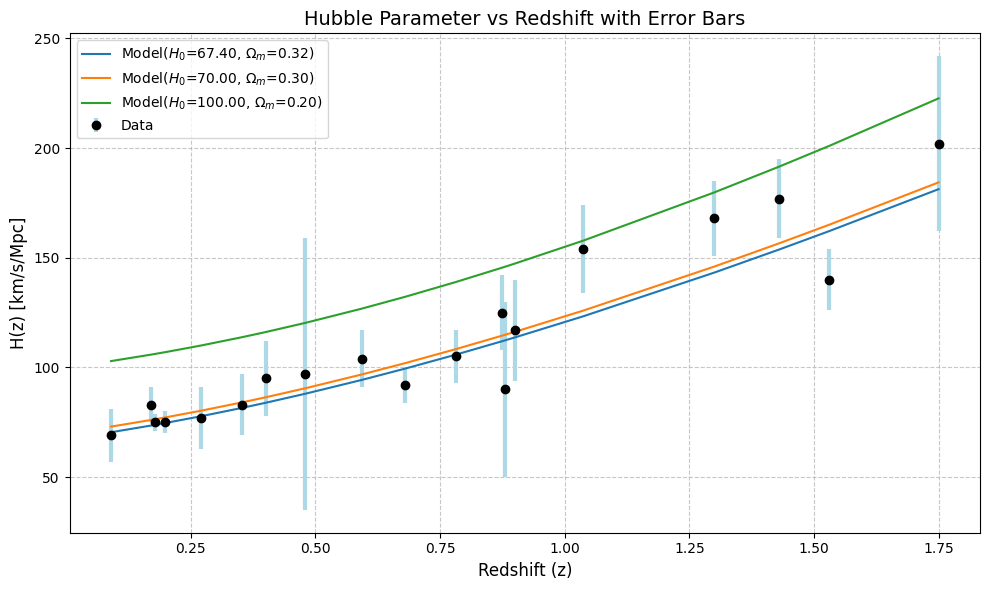

In [6]:
error_plot(z, H, params=[(67.4, 0.315), (70, 0.3), (100, 0.2)])

For the likelihood, $p(D|H_0, \Omega_m)$, we can assume a Gaussian likelihood, given the measurement uncertainties (`Herr`) that are provided in the data. In the case of this example, the data is composed of $H_i$ measurements at different $z_i$ s, with uncertainties $\sigma_i$ s respectively. The Gaussian likelihood is then be computed as

$p(D|H_0, \Omega_m) = \prod_{i=1} p(D_i|H_0, \Omega_m) = \prod_{i=1} e^{\frac{-(H_i − H(z_i, H_0, \Omega_m))^2}{\sigma^2_i}}$

where $H(z_i, H_0, \Omega_m)$ is the evaluation of the model (normalization constant) at $z_i$.

The Gaussian likelihood can also be written as,

$p(D|H_0, \Omega_m) = e^{\frac{-\chi^2}{2}}$

where, $ \chi^2 = \sum_i {\frac{(H_i − H(z_i, H_0, \Omega_m))^2}{\sigma^2_i}}$

#### 2. Define python functions for the model, the posterior (likelihood times prior) and the proposal distribution. For the prior distribution on the parameters, you can start by using a uniform prior over $50 < H_0 < 100$ and $0 < \Omega_m < 1$

In [7]:
def likelihood_chi_sq(z, H, Herr, H0, omega_m):
    """chi-square likelihood"""
    chi_sq = 0 
    for i in range(len(z)):
        chi_sq += ((H[i] - model(z[i], H0, omega_m))**2) / Herr[i]**2
    return np.exp(-chi_sq/2.)

In [8]:
def get_priors(H0, omega_m, H_low=50, H_up=100, omega_low=0, omega_up=1, gaussian_omega=False):
    """Initialization of priors for H0 and omega_m parameters as unfiorm distribution"""
    H0 = 1 if H_low < H0 < H_up else 0
    if gaussian_omega:
        omega_m = (1 / np.sqrt(2 * np.pi * 0.007**2)) * np.exp(-0.5 * ((omega_m - 0.315)**2 / 0.007**2))
    else:
        omega_m = 1 if omega_low < omega_m < omega_up else 0
    return H0, omega_m

In [9]:
def posterior(z, H, herr, H0, omega_m, gaussian_omega=False):
    """posterior probability based on likelihood and priors"""
    prior_H0, prior_omega = get_priors(H0, omega_m, gaussian_omega)
    likelihood = likelihood_chi_sq(z, H, herr, H0, omega_m)
    return likelihood * prior_H0 * prior_omega

In [10]:
def proposal(H0, omega_m, prop_width_H0=0.5, prop_width_omega=0.02):
    """Propose new values for H0 and omega_m based on a Gaussian perturbation."""
    H0_new = np.random.normal(H0, prop_width_H0)
    omega_m_new = np.random.normal(omega_m, prop_width_omega)
    return H0_new, omega_m_new

#### 3. Write your MCMC code and run 4 or 5 chains, initializing them at different locations in the two parameters. Study them, plotting the parameters against the chain step, and cut out the burn-in regions.

In [11]:
def metropolis_hasting(z, H, Herr, Nsim=10**5, H0_init=60, omega_m_init=0.2, gaussian_omega=False):
    """Metropolis Hastings MCMC for cosmological model."""
    chain = np.zeros((Nsim, 3))
    chain[0] = H0_init, omega_m_init, posterior(z, H, Herr, H0_init, omega_m_init)
    count_accepted = 0 

    for i in range(Nsim - 1):
        H0_prop, omega_m_prop = proposal(chain[i, 0], chain[i, 1])
        posterior_prop = posterior(z, H, Herr, H0_prop, omega_m_prop, gaussian_omega)
        posterior_current = chain[i, 2]

        ratio = posterior_prop / posterior_current if posterior_current != 0 else 1
        if ratio >= 1 or ratio > np.random.random():
            chain[i + 1] = H0_prop, omega_m_prop, posterior_prop
            count_accepted += 1
        else:
            chain[i + 1] = chain[i]

    efficiency = count_accepted / Nsim
    print(f"Chain efficiency: {efficiency:.3f}")
    print(f"H0 mean: {chain[:, 0].mean():.2f}, omega_m mean: {chain[:, 1].mean():.3f}")
    print(f"H0 sd: {chain[:, 0].std():.2f}, omega_m sd: {chain[:, 1].std():.2f}")
    print("="*20)
    
    return chain

#### 4. Study the efficiency of the chains (steps accepted / steps proposed) and the convergence, running several independent chains starting from different points and checking that you get consistent posteriors.

In [12]:
metropolis_hasting(z, H, Herr, Nsim=10**4, H0_init=60, omega_m_init=0.2)
metropolis_hasting(z, H, Herr, Nsim=10**4, H0_init=68, omega_m_init=0.3)
metropolis_hasting(z, H, Herr, Nsim=10**4, H0_init=70, omega_m_init=0.3)
metropolis_hasting(z, H, Herr, Nsim=10**4, H0_init=80, omega_m_init=0.5)
chain = metropolis_hasting(z, H, Herr, Nsim=10**4, H0_init=100, omega_m_init=0.7)

Chain efficiency: 0.797
H0 mean: 68.43, omega_m mean: 0.327
H0 sd: 2.81, omega_m sd: 0.06
Chain efficiency: 0.792
H0 mean: 68.11, omega_m mean: 0.338
H0 sd: 3.20, omega_m sd: 0.07
Chain efficiency: 0.787
H0 mean: 68.76, omega_m mean: 0.323
H0 sd: 3.04, omega_m sd: 0.06
Chain efficiency: 0.784
H0 mean: 68.48, omega_m mean: 0.332
H0 sd: 3.47, omega_m sd: 0.06
Chain efficiency: 0.787
H0 mean: 68.26, omega_m mean: 0.340
H0 sd: 4.76, omega_m sd: 0.07


#### 5. From the samples of the chains, make a 2D density plot of H0,Ωm, and also make 1D plots of the histogram of each parameter (do they look Gaussian?). Calculate the 68% confidence interval around the mode of the distribution on each of the two parameters (please do it by counting on the histogram of the samples and not computing the standard deviation, as it could be non-symmetric).

##### Chain Plots of the parameters

In [13]:
def plot_markov_chain(chain, burnin_period=100, remove_burnin=True):
    if remove_burnin:
        chain = chain[burnin_period:]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    ax1.plot(chain[:,0], color='b', lw=2, alpha=0.7, label=r'$H_0$')
    ax1.set_xlabel(r'Chain step')
    ax1.axvspan(0, burnin_period, color='tomato', alpha=0.1, label='Burn-in')
    ax1.legend(loc="upper right")
    ax1.set_xscale('log')
    ax1.set_title('Markov Chain Progression')

    ax2.plot(chain[:,1], color='g', lw=2, alpha=0.9, label=r'$\Omega_m$')
    ax2.set_xlabel(r'Chain step')
    ax2.axvspan(0, burnin_period, color='tomato', alpha=0.1, label='Burn-in')
    ax2.legend(loc="upper right")
    ax2.set_xscale('log')

    plt.suptitle(f"Markov Chain Progression")
    plt.tight_layout()
    plt.show()

The fluctuations in $H_0$ is very large compared to $\Omega_m$, so in a single plot it seems like $\Omega_m$ has almost no fluctuations. Separate plot shows a better view of the Monte Carlo chain on individual parameters.

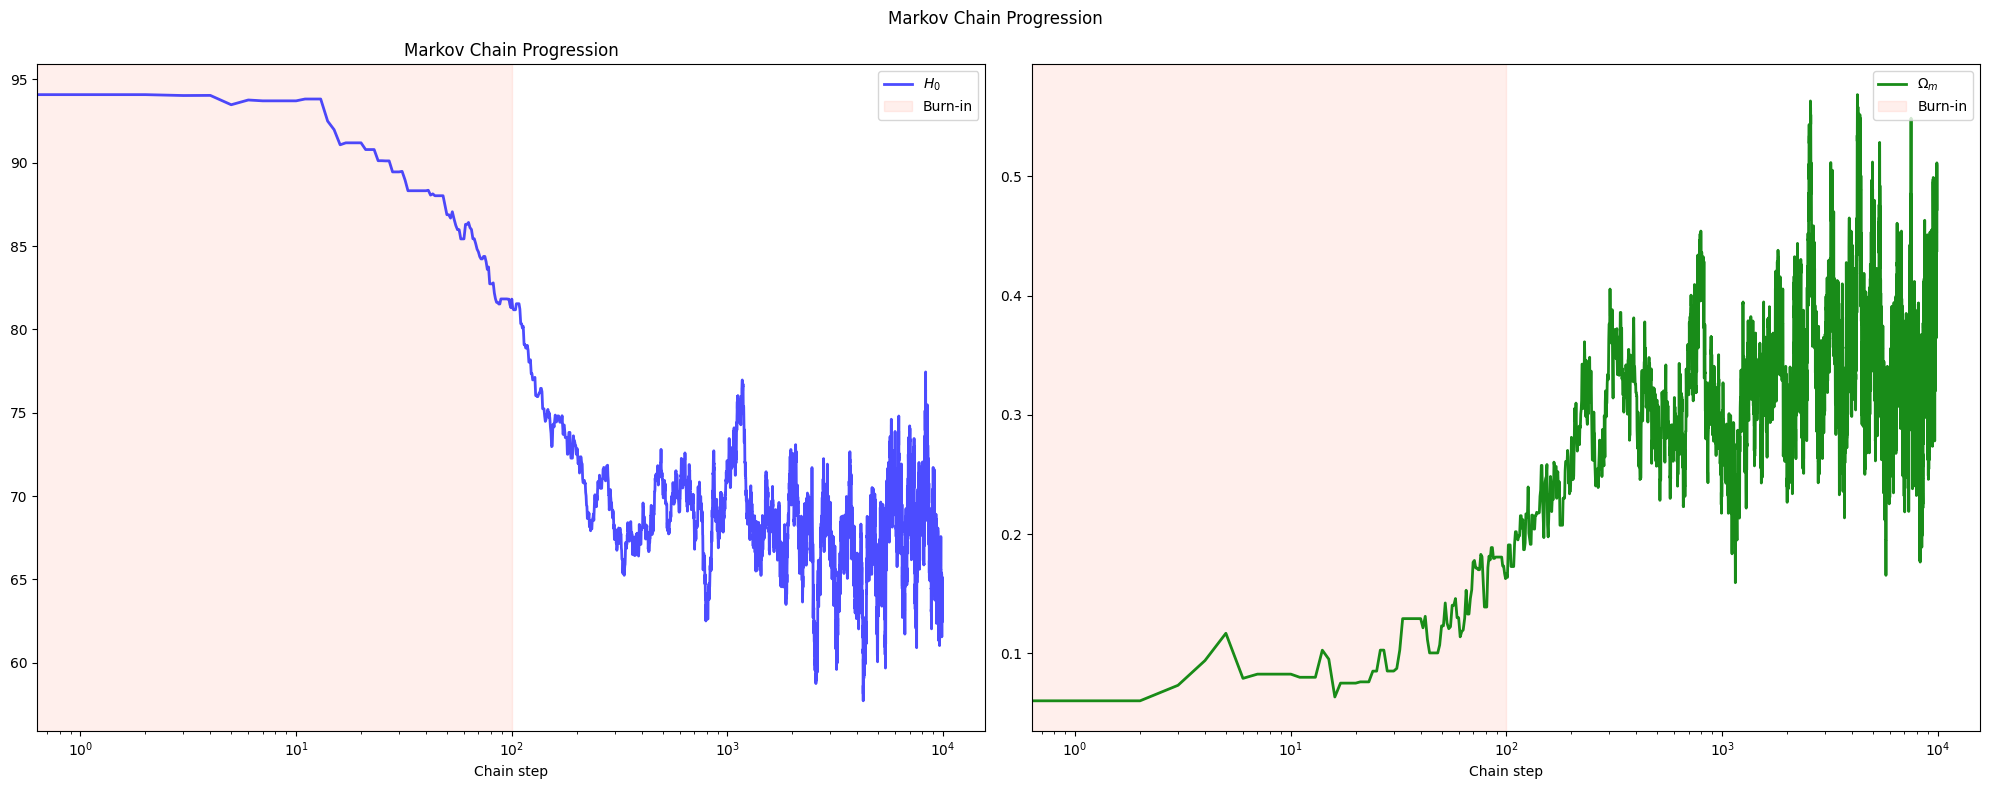

In [14]:
plot_markov_chain(chain)

##### 2D density Plot

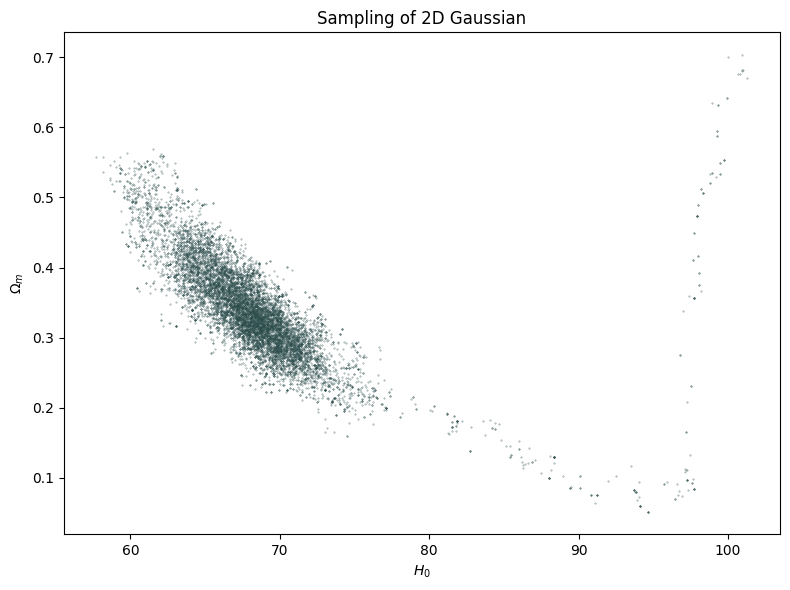

In [15]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(chain[:,0], chain[:, 1], s=0.1, color='darkslategrey', alpha=0.7)
plt.xlabel(r'$H_0$')
plt.ylabel(r'$\Omega_m$')
plt.title(r'Sampling of 2D Gaussian')

plt.tight_layout()
plt.show()

##### 1D Histogram plots of the chains with  68% confidence interval around the mode

68% CI on $H_0$: 6.87
68% CI on $\Omega_m$: 0.13


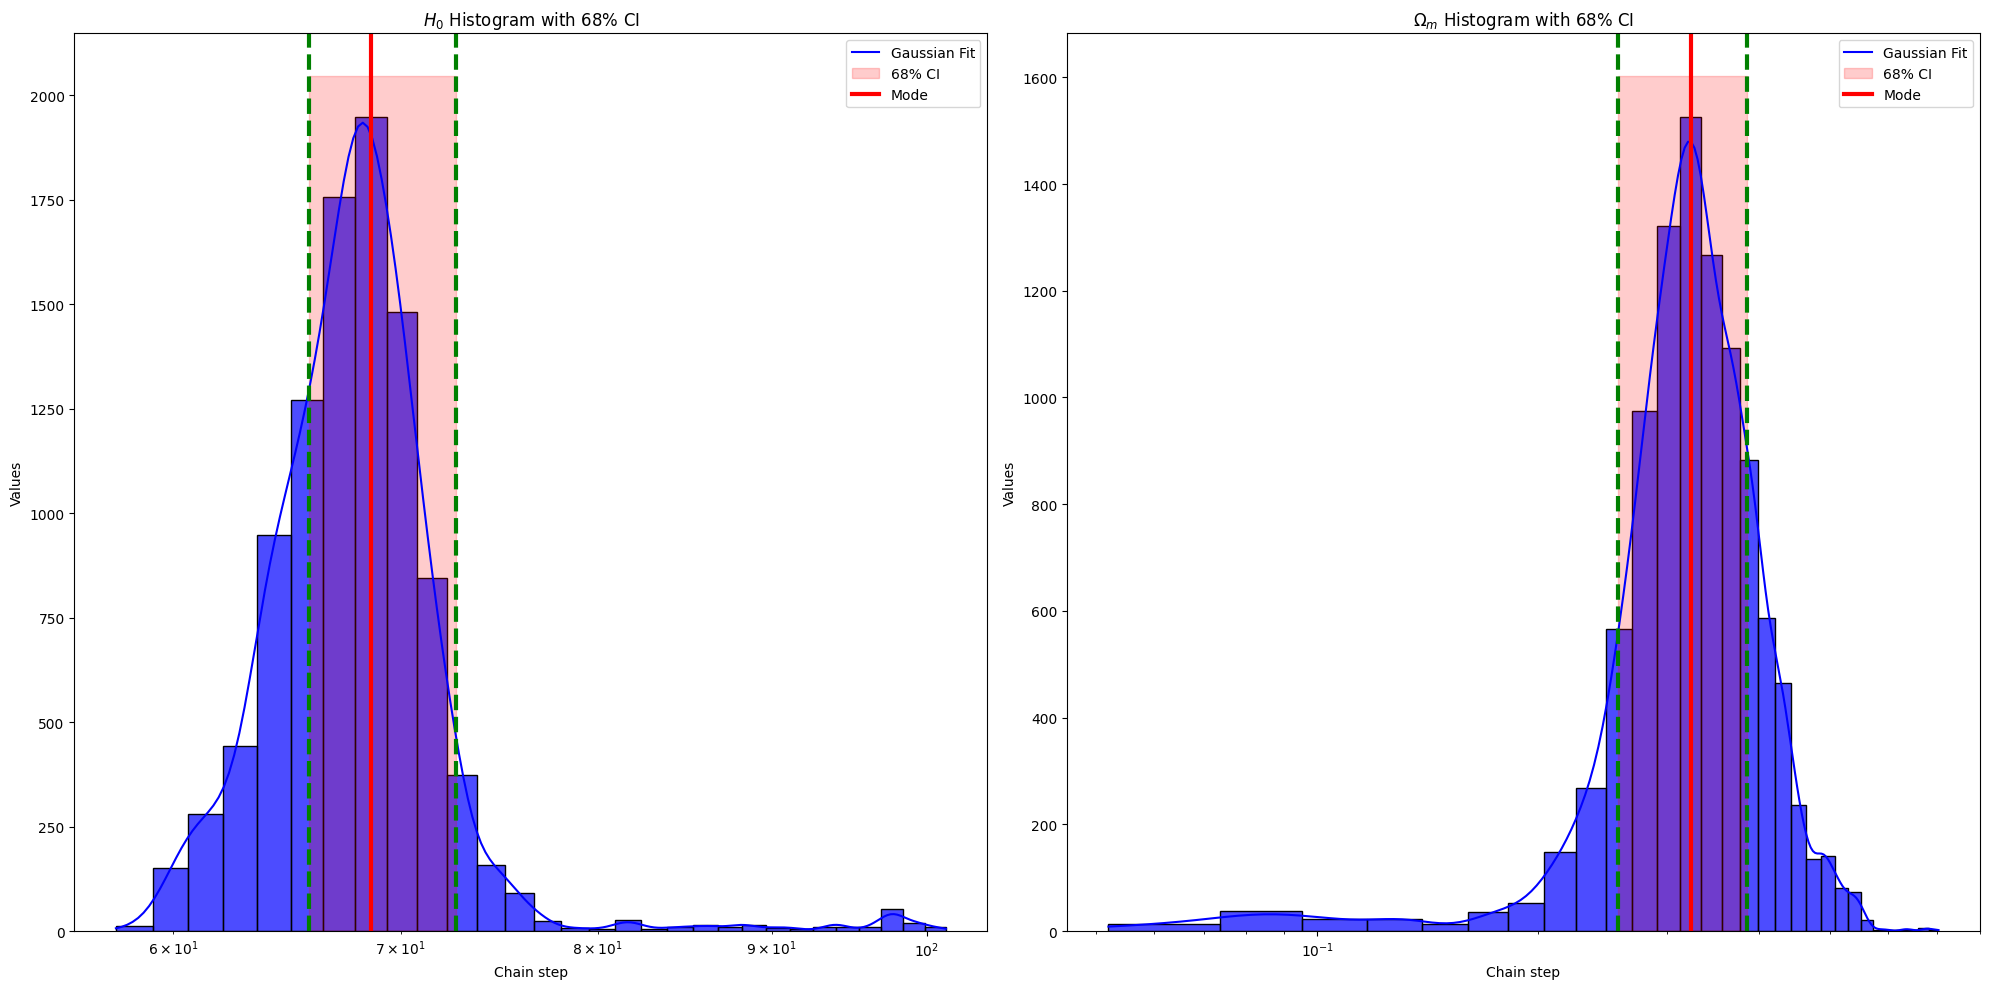

In [26]:
import seaborn as sns

def plot_histograms_with_ci(chains, params, CI):
    fig, axes = plt.subplots(1, len(params), figsize=(20, 10))
    
    for i in range(len(params)):
        counts, bin_edges = np.histogram(chains[:, i], bins=30)
        mode_idx = np.argmax(counts)
        mode = (bin_edges[mode_idx] + bin_edges[mode_idx + 1]) / 2
        
        sorted_samples = np.sort(chains[:, i])
        conf_interval = int(CI * len(sorted_samples))
        mode_idx_in_sorted = np.searchsorted(sorted_samples, mode)
        
        lower_idx = max(0, mode_idx_in_sorted - conf_interval // 2)
        upper_idx = min(len(sorted_samples) - 1, mode_idx_in_sorted + conf_interval // 2)
        
        lower_bound = sorted_samples[lower_idx]
        upper_bound = sorted_samples[upper_idx]
        print(f"68% CI on {params[i]}: {np.round(upper_bound-lower_bound, 2)}")
        
        histplot = sns.histplot(chains[:, i], kde=True, bins=30, alpha=0.7, ax=axes[i], color='b')
        kde_line = histplot.lines[0]
        kde_line.set_label('Gaussian Fit')

        axes[i].fill_betweenx([0, axes[i].get_ylim()[1]], lower_bound, upper_bound, color='r', alpha=0.2, label='68% CI')
        axes[i].axvline(lower_bound, color='g', linestyle='--', linewidth=3)
        axes[i].axvline(upper_bound, color='g', linestyle='--', linewidth=3)
        axes[i].axvline(mode, color='r', linestyle='-', label='Mode', linewidth=3)
        axes[i].set_xscale('log')
        axes[i].set_xlabel('Chain step')
        axes[i].set_ylabel('Values')

        axes[i].set_title(f'{params[i]} Histogram with {int(CI*100)}% CI')
        axes[i].legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()

params = [r'$H_0$', r'$\Omega_m$']
plot_histograms_with_ci(chain, params, CI=0.68)

### 6. Repeat the plot of point 1, but now with parameter combinations drawn directly from the posterior.

Chain efficiency: 0.600
H0 mean: 60.61, omega_m mean: 0.222
H0 sd: 0.52, omega_m sd: 0.02


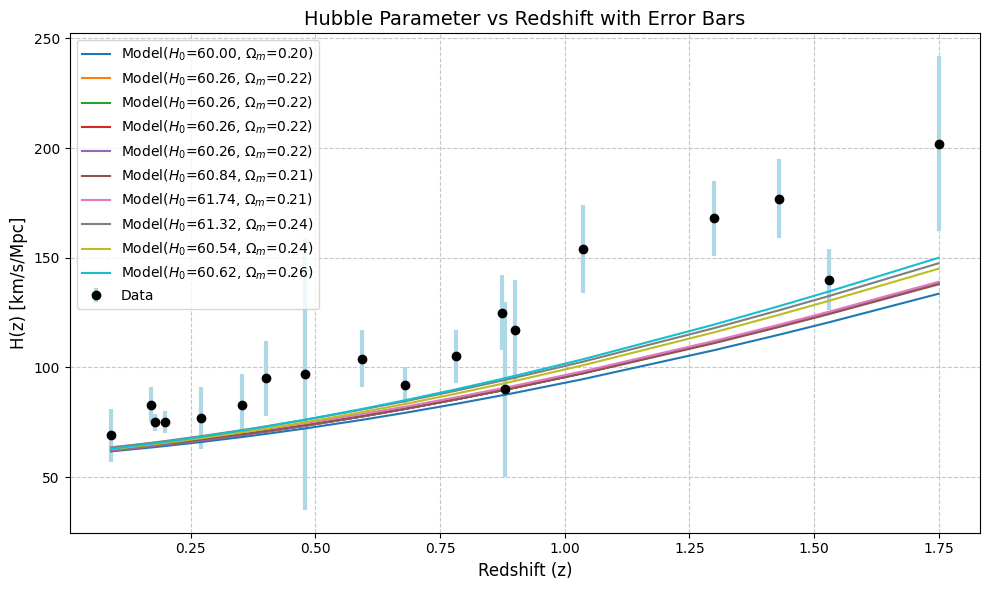

In [17]:
chain_10 = metropolis_hasting(z, H, Herr, Nsim=10, H0_init=60, omega_m_init=0.2)

H0_omega_posterior = zip(chain_10[:, 0], chain_10[:, 1])
error_plot(z, H, params=list(H0_omega_posterior))

Chain efficiency: 0.740
H0 mean: 61.30, omega_m mean: 0.420
H0 sd: 0.96, omega_m sd: 0.09


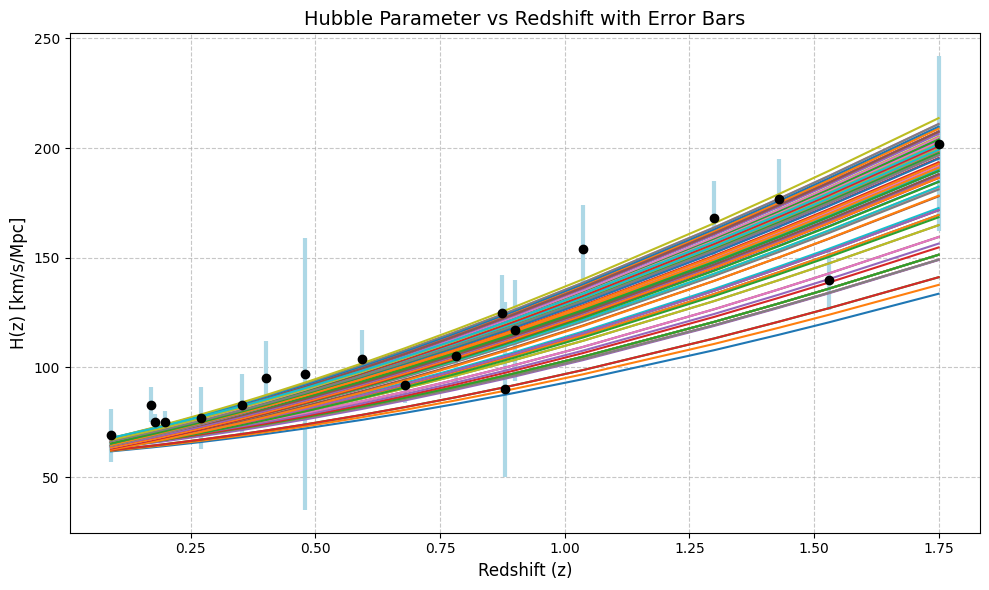

In [18]:
chain_100 = metropolis_hasting(z, H, Herr, Nsim=100, H0_init=60, omega_m_init=0.2)

H0_omega_posterior = zip(chain_100[:, 0], chain_100[:, 1])
error_plot(z, H, params=list(H0_omega_posterior), legend=False)

#### 7. Finally, repeat the whole exercise but now using a Gaussian prior on Ωm = 0.315 ±0.007, given by measurements of the Planck Satellite. This is a good example on how to use prior information in our analysis. What is the new 68% confidence interval on H0? Comment on why is it larger or smaller. And what is the new 68% confidence interval on Ωm, and why? Please do all the above checks on the sanity of the chains in this case.

In [27]:
chain_gaussian_omega = metropolis_hasting(z, H, Herr, Nsim=100, H0_init=60, omega_m_init=0.2, gaussian_omega=True)


Chain efficiency: 0.790
H0 mean: 64.13, omega_m mean: 0.349
H0 sd: 2.10, omega_m sd: 0.05


68% CI on $H_0$: 5.08
68% CI on $\Omega_m$: 0.06


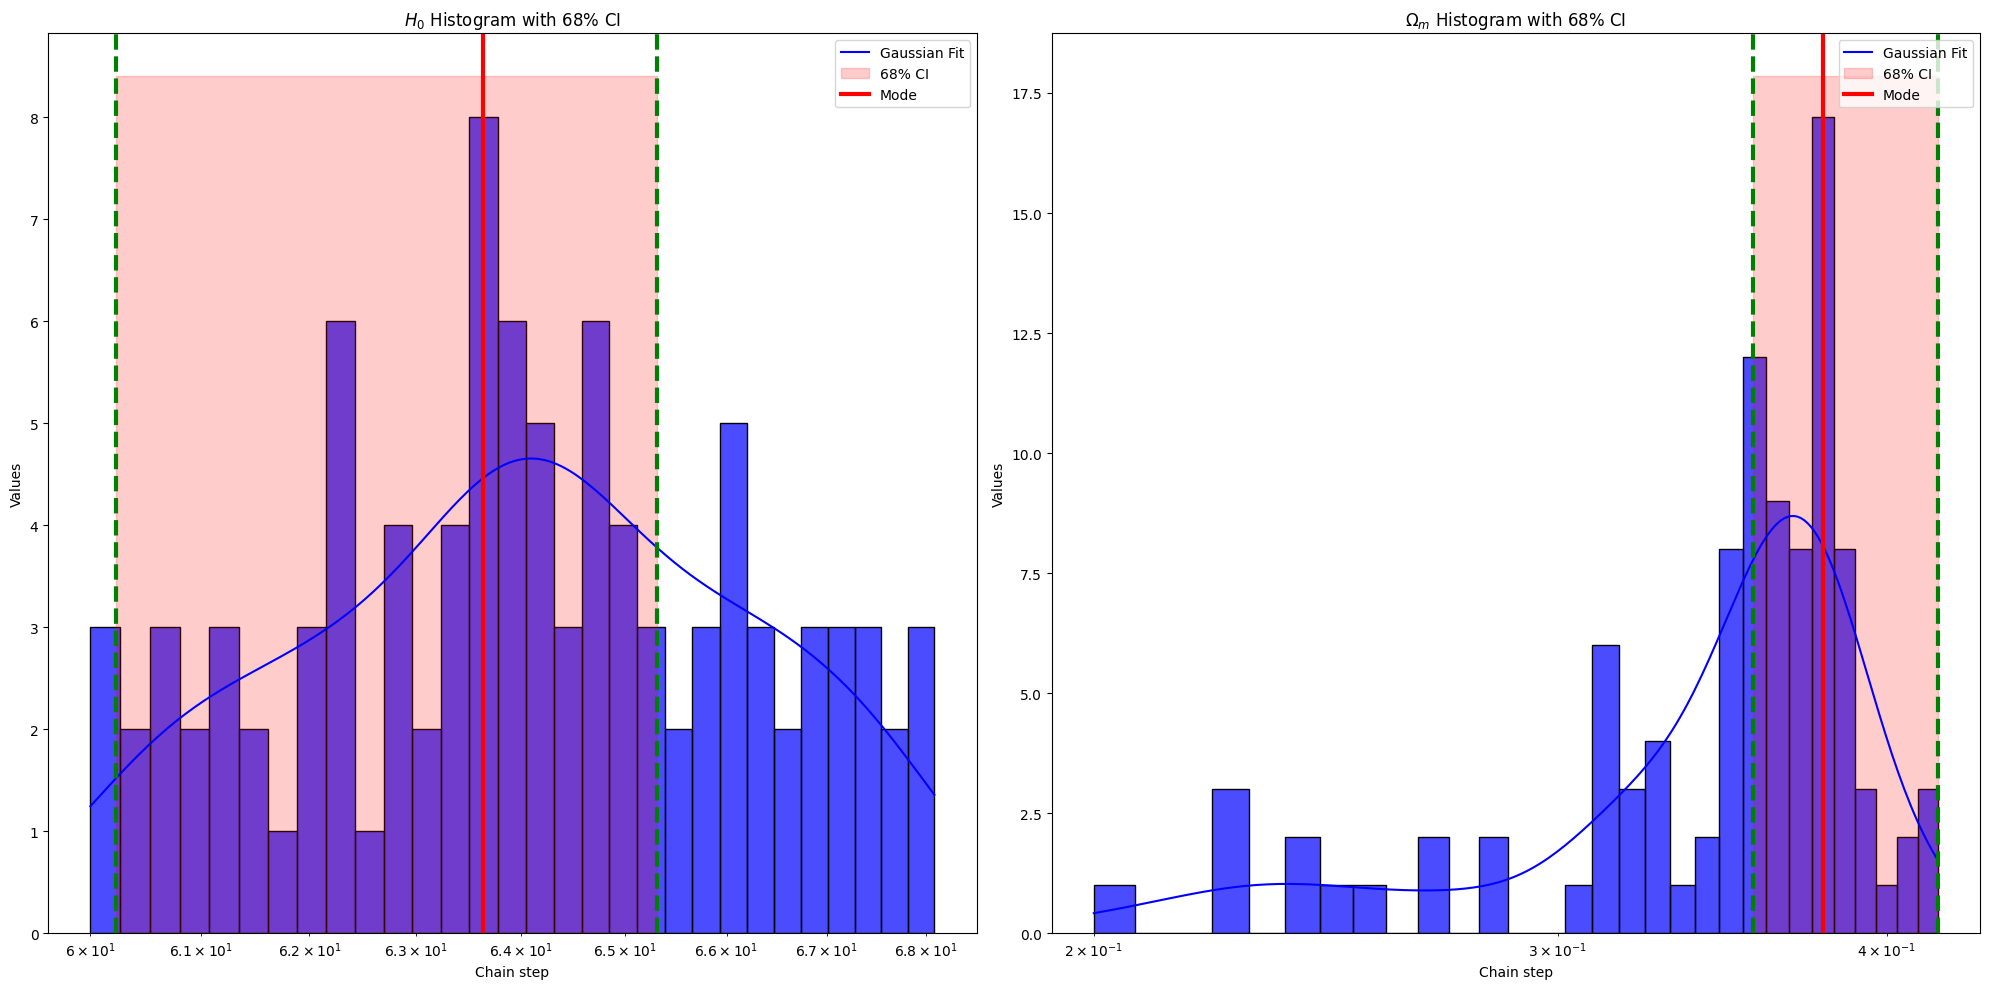

In [28]:
plot_histograms_with_ci(chain_gaussian_omega, params=[r'$H_0$', r'$\Omega_m$'], CI=0.68)

##### Analysis on 68% Confidence Intervals

What is the new 68% confidence interval on $H_0$? Comment on why is it larger or smaller. And what is the new 68% confidence interval on $\Omega_m$, and why? Please do all the above checks on the sanity of the chains in this case.

- Previously, we used uniform distribution with a vage range of priors as $50 < H_0 < 100$ and $0 < \Omega_m < 1.$. Since prior here is non-informative in the sense that it doesn't favor a specific vlaue or constrained range of values, the parameters are sampled across the broad allowed range, and the sampling will be driven more by the likelihood function.

- In the case of $H_0$, we have not changed the prior, so the confidence interval of $H_0$ is largely unaffected: 6.87 and 5.08. However, this slight change  might be due to dependency between $H_0$ and $\Omega_m$ in the model causing some indirect impact, or just because of the random nature of Monte Carlo sampling.

- However, in the case of $\Omega_m$, we have constrained the prior from a broad range of [0, 1] to [0.308, 0.322], which will definitely constrain the confidence interval. The Gaussian prior on $\Omega_m$, centered around 0.315 with a standard deviation of 0.007, introduces a strong prior belief about its value, which as the simulation step increses pushes the $\Omega_m$ value closer to the mean resulting in a tigter distribution around 0.315. 
